# Data imputation
[TOC]

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from mlens.visualization import pca_comp_plot
from matplotlib import pyplot as plt

from data import feature, get_severity, z_score_normalize, z_score_denormalize, fill_dataset

seed = 0

def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, gamma=1e-3, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=8)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((32, 64, 16), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=64, random_state=seed)
    rf = RandomForestClassifier(n_estimators=64, max_features=2, random_state=seed)
    ab = AdaBoostClassifier(n_estimators=64, random_state=seed)
    xgb = XGBClassifier(random_state=seed)        
    models = {'svm': svc, 
              'knn': knn, 
              'naive bayes': nb,
              'mlp': nn,
              'random forest': rf,
              'gradient boost': gb,
              'logistic': lr,
              'adaboost': ab,
              'xgboost': xgb, 
             }
    return models

def sensitivity_specificity(cm):
    return cm[1, 1] / np.sum(cm[1]), cm[0, 0] / np.sum(cm[0])

def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            print('no sample weight')
            m.fit(x_train, y_train)
        try:
            print('\n', name, m.feature_importances_)
        except:
            print('no feature importances')
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def cross_val_models(model_list, cv=5, scoring='accuracy'):
    P = np.zeros((cv, len(model_list)))
    P = pd.DataFrame(P)

    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        P.iloc[:, i] = cross_val_score(m, X, y, cv=cv, scoring=scoring)
        cols.append(name)
        print("done")
    P.columns = cols
    print('Done.\n')
    return P

def cross_val_acc(P, scoring='ACC'):
    for m in P.columns:
        score = np.mean(P.loc[:, m])
        std = 2 * np.std(P.loc[:, m])
        print('{} {} Result {} +/- {}'.format(m, scoring, score, std))

def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))

def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    #cm = [plt.cm.gray(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1])]
    cm = sns.color_palette("Blues", P_base_learners.shape[1])
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c='red')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    feature_importances = {}
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            m.fit(x_train, y_train)
            print('no sample_weight')
        try:
            feature_importances.update({name: m.feature_importances_})
        except:
            print('no feature importances')
    print('done.')
    return feature_importances

def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P

def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

Using TensorFlow backend.
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

## Read data

In [2]:
method = 'knn_3'
# method = 'knn_6'
# method = 'knn_9'
# method = 'softimpute'

In [3]:
train_data_path = './csv/filled_trainSet/filled_{}_trainSet_binary.txt'.format(method)
test_data_path = './csv/filled_testSet/filled_{}_testSet_binary.txt'.format(method)

In [4]:
train_dataset = pd.read_csv(train_data_path, sep=',')
test_dataset = pd.read_csv(test_data_path, sep=',')

y = np.array(train_dataset['severity'])

## Clinical data prediction
Select **imputation** method you want to verify here.

In [5]:
X = z_score_normalize(np.array(train_dataset[feature]))

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


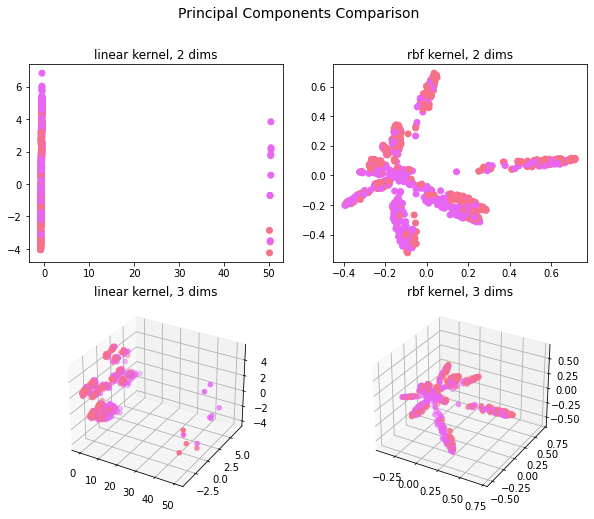

[<AxesSubplot:title={'center':'linear kernel, 2 dims'}>,
 <AxesSubplot:title={'center':'rbf kernel, 2 dims'}>,
 <Axes3DSubplot:title={'center':'linear kernel, 3 dims'}>,
 <Axes3DSubplot:title={'center':'rbf kernel, 3 dims'}>]

In [6]:
pca_comp_plot(X, y)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

样本集大小： (863, 16) (863,)
训练集大小： (690, 16) (690,)
测试集大小： (173, 16) (173,)


In [8]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models...
svm... no sample weight
no feature importances
done
knn... no sample weight
no feature importances
done
naive bayes... no sample weight
no feature importances
done
mlp... no sample weight
no feature importances
done
random forest... no sample weight

 random forest [0.08414898 0.01341763 0.05511732 0.01173698 0.01849438 0.06836352
 0.09659768 0.07685529 0.13295968 0.07505649 0.09631584 0.08715593
 0.11302606 0.05623354 0.01265493 0.00186574]
done
gradient boost... no sample weight

 gradient boost [0.10572343 0.00190079 0.01749191 0.00341382 0.00911837 0.02677462
 0.08118731 0.05601029 0.31709953 0.03051983 0.0947662  0.11321067
 0.11396874 0.02881449 0.         0.        ]
done
logistic... no sample weight
no feature importances
done
adaboost... no sample weight

 adaboost [0.140625 0.015625 0.0625   0.       0.015625 0.046875 0.125    0.109375
 0.125    0.09375  0.046875 0.09375  0.078125 0.046875 0.       0.      ]
done
xgboost... no sample weight

 xgboost [0.0813

In [9]:
models = get_models()
cv_results=cross_val_models(models)
cross_val_acc(cv_results)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... 

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ACC Result 0.7358179862884796 +/- 0.014799881901389185
knn ACC Result 0.6686113724963032 +/- 0.014052532300451337
naive bayes ACC Result 0.7068355961822825 +/- 0.04491495803088668
mlp ACC Result 0.6928821078101896 +/- 0.07499557311663813
random forest ACC Result 0.745073262535287 +/- 0.02650826450492273
gradient boost ACC Result 0.7276784514047587 +/- 0.029888203491139163
logistic ACC Result 0.7335260115606936 +/- 0.03980805654933945
adaboost ACC Result 0.7230877806156741 +/- 0.05866091561503644
xgboost ACC Result 0.709167898911144 +/- 0.045584874737095604


In [10]:
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost
0,0.728324,0.664740,0.710983,0.710983,0.757225,0.739884,0.716763,0.739884,0.739884
1,0.734104,0.670520,0.734104,0.722543,0.734104,0.716763,0.710983,0.670520,0.682081
2,0.734104,0.658960,0.676301,0.687861,0.745665,0.739884,0.739884,0.734104,0.693642
3,0.732558,0.668605,0.686047,0.720930,0.726744,0.703488,0.732558,0.715116,0.732558
4,0.750000,0.680233,0.726744,0.622093,0.761628,0.738372,0.767442,0.755814,0.697674


In [11]:
cv_results_roc=cross_val_models(models, scoring='roc_auc')
cross_val_acc(cv_results_roc, scoring='ROC AUC')

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... 

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ROC AUC Result 0.8187875714549143 +/- 0.032126584382415016
knn ROC AUC Result 0.7491738889913332 +/- 0.05128602983936832
naive bayes ROC AUC Result 0.8085506177392588 +/- 0.03651836040827446
mlp ROC AUC Result 0.7319019300510172 +/- 0.09685527342782305
random forest ROC AUC Result 0.8271782223861331 +/- 0.029385258026705902
gradient boost ROC AUC Result 0.8091944802999571 +/- 0.041354361402172496
logistic ROC AUC Result 0.8190604831274202 +/- 0.046367313762364123
adaboost ROC AUC Result 0.7876289261786218 +/- 0.06770427203510881
xgboost ROC AUC Result 0.7858620689655174 +/- 0.03874405552898009


In [12]:
print("Voting ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))
print("Voting ACC score: %.3f" % accuracy_score(y_test, np.float32(P.mean(axis=1) > 0.5)))

Voting ROC-AUC score: 0.836
Voting ACC score: 0.780


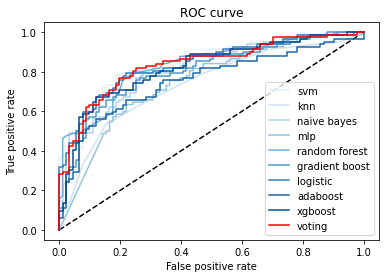

In [13]:
plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), 'voting')

In [14]:
base_learners = get_models()

In [15]:
meta_learner = GradientBoostingClassifier(
   n_estimators=128,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=seed
)

In [16]:
train_base_learners(base_learners, x_train, y_train)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.


{'random forest': array([0.08414898, 0.01341763, 0.05511732, 0.01173698, 0.01849438,
        0.06836352, 0.09659768, 0.07685529, 0.13295968, 0.07505649,
        0.09631584, 0.08715593, 0.11302606, 0.05623354, 0.01265493,
        0.00186574]),
 'gradient boost': array([0.10572343, 0.00190079, 0.01749191, 0.00341382, 0.00911837,
        0.02677462, 0.08118731, 0.05601029, 0.31709953, 0.03051983,
        0.0947662 , 0.11321067, 0.11396874, 0.02881449, 0.        ,
        0.        ]),
 'adaboost': array([0.140625, 0.015625, 0.0625  , 0.      , 0.015625, 0.046875,
        0.125   , 0.109375, 0.125   , 0.09375 , 0.046875, 0.09375 ,
        0.078125, 0.046875, 0.      , 0.      ]),
 'xgboost': array([0.08139775, 0.05805709, 0.04106136, 0.04427364, 0.0560831 ,
        0.05113155, 0.05924238, 0.07008824, 0.17858392, 0.04138776,
        0.10191695, 0.07264745, 0.07621885, 0.05117882, 0.01673114,
        0.        ], dtype=float32)}

In [17]:
P_base = predict_base_learners(base_learners, x_train)
P_test = predict_base_learners(base_learners, x_test)

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.


In [18]:
meta_learner.fit(P_base, y_train)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=128, random_state=0,
                           subsample=0.5)

In [19]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nStacking ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Stacking ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Stacking ROC-AUC score: 0.793
Stacking ACC score: 0.769


In [20]:
c = 0
for k, v in base_learners.items():
    print("{} ROC-AUC score: %.3f".format(k) % roc_auc_score(y_test, P_pred[:, c]))
    print("{} ACC score: %.3f \n".format(k) % accuracy_score(y_test, np.float32(P_pred[:, c] > 0.5)))
    c = c + 1

svm ROC-AUC score: 0.842
svm ACC score: 0.798 

knn ROC-AUC score: 0.738
knn ACC score: 0.699 

naive bayes ROC-AUC score: 0.816
naive bayes ACC score: 0.728 

mlp ROC-AUC score: 0.751
mlp ACC score: 0.688 

random forest ROC-AUC score: 0.832
random forest ACC score: 0.746 

gradient boost ROC-AUC score: 0.804
gradient boost ACC score: 0.711 

logistic ROC-AUC score: 0.839
logistic ACC score: 0.786 

adaboost ROC-AUC score: 0.754
adaboost ACC score: 0.682 

xgboost ROC-AUC score: 0.822
xgboost ACC score: 0.734 



In [21]:
index = train_dataset[feature].index

## 5-fold validation

In [22]:
idx = list(index)
np.random.shuffle(idx)
X_ = X[idx]
y_ = y[idx]
cls_data_voting = train_dataset.copy().reset_index(drop=True)
cls_data_voting = cls_data_voting.iloc[idx]
cls_data_voting = cls_data_voting.reset_index(drop=True)
cv_scores_vote = []
feature_importances_list = []
prob = pd.DataFrame(columns=base_learners.keys(), dtype='float32')
for i, (train_idx, test_idx) in enumerate(KFold(5).split(X_)):
    fold_x_train, fold_y_train = X_[train_idx, :], y_[train_idx]
    fold_x_test, fold_y_test = X_[test_idx, :], y_[test_idx]
    
    base_learners = get_models()

    feature_importances = train_base_learners(base_learners, fold_x_train, fold_y_train)
    P_test = predict_base_learners(base_learners, fold_x_test)
    for i, model_name in zip(range(len(base_learners.keys())), base_learners.keys()):
        cls_data_voting.loc[test_idx, model_name] = P_test[:, i]
    
    p_vote = P_test.mean(axis=1)
    fold_y_pred = np.float32(p_vote > 0.5)
    
    acc = accuracy_score(fold_y_test, fold_y_pred)
    recall = recall_score(fold_y_test, fold_y_pred)
    cm = confusion_matrix(fold_y_test, fold_y_pred)
    roc = roc_auc_score(fold_y_test, p_vote)
    
    cls_data_voting.loc[test_idx, 'pred'] = fold_y_pred
    cls_data_voting.loc[test_idx, 'prob'] = p_vote
    prob = pd.concat([prob, pd.DataFrame(P_test, columns=base_learners.keys())])

    print("\nEnsemble ROC-AUC score: %.3f" % roc)
    print("Ensemble ACC score: %.3f" % acc)
    
    cv_scores_vote.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})
    feature_importances_list.append(feature_importances)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Ensemble ROC-AUC score: 0.849
Ensemble ACC score: 0.798
Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predict

In [23]:
feature_stacking = pd.DataFrame(pd.DataFrame(feature_importances_list).sum().to_dict(), index=feature)
feature_stacking['sum'] = feature_stacking.sum(axis=1)
feature_stacking = feature_stacking.sort_values(by='sum')

In [24]:
feature_stacking.to_csv('csv/feature_importance/filled_{}_binary.csv'.format(method))

In [25]:
pd.DataFrame(cv_scores_vote)

,acc,recall,confusion_matrix,roc_auc_score
0,0.797688,0.738636,"[[73, 12], [23, 65]]",0.849198
1,0.710983,0.678571,"[[66, 23], [27, 57]]",0.777154
2,0.751445,0.655556,"[[71, 12], [31, 59]]",0.827845
3,0.767442,0.702381,"[[73, 15], [25, 59]]",0.843074
4,0.703488,0.632911,"[[71, 22], [29, 50]]",0.801279


In [26]:
np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])

array([[354,  84],
       [135, 290]], dtype=int64)

Text(33.0, 0.5, 'True labels')

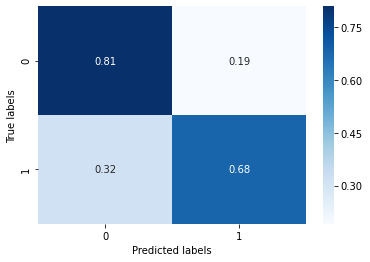

In [27]:
cm = np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Blues', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [28]:
cv_results['voting'] = pd.DataFrame(cv_scores_vote)['acc']
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost,voting
0,0.728324,0.664740,0.710983,0.710983,0.757225,0.739884,0.716763,0.739884,0.739884,0.797688
1,0.734104,0.670520,0.734104,0.722543,0.734104,0.716763,0.710983,0.670520,0.682081,0.710983
2,0.734104,0.658960,0.676301,0.687861,0.745665,0.739884,0.739884,0.734104,0.693642,0.751445
3,0.732558,0.668605,0.686047,0.720930,0.726744,0.703488,0.732558,0.715116,0.732558,0.767442
4,0.750000,0.680233,0.726744,0.622093,0.761628,0.738372,0.767442,0.755814,0.697674,0.703488


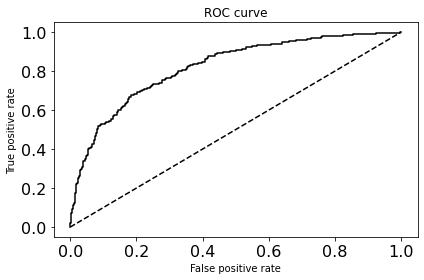

In [29]:
fpr, tpr, _ = roc_curve(cls_data_voting['severity'], cls_data_voting['prob'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Voting', c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend()
plt.tick_params(labelsize=16)
plt.tight_layout()

plt.savefig('fig/filled_{}_binary.png'.format(method), format='png')

In [30]:
thres = 0.50

In [31]:
acc = accuracy_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
recall = recall_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
cm = confusion_matrix(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
roc = roc_auc_score(cls_data_voting['severity'], cls_data_voting['prob'])
sensitivity, specificity = sensitivity_specificity(cm)

print('roc auc score: \t{}'.format(roc))
print('accuarcy: \t{}'.format(acc))
print('recall: \t{}'.format(recall))
print('sensitivity: \t{}'.format(sensitivity))
print('specificity: \t{}'.format(specificity))
print('confusion matrix: \n{}'.format(cm))

roc auc score: 	0.8198227236099919
accuarcy: 	0.746234067207416
recall: 	0.6823529411764706
sensitivity: 	0.6823529411764706
specificity: 	0.8082191780821918
confusion matrix: 
[[354  84]
 [135 290]]


In [32]:
results = pd.DataFrame(index=base_learners.keys(), columns=['roc', 'acc', 'recall', 'cm', 'sensitivity', 'specificity'], dtype='object')
for k in base_learners.keys():
    acc = accuracy_score(cls_data_voting['severity'], prob[k] > thres)
    recall = recall_score(cls_data_voting['severity'], prob[k] > thres)
    cm = confusion_matrix(cls_data_voting['severity'], prob[k] > thres)
    roc = roc_auc_score(cls_data_voting['severity'], prob[k])
    sensitivity, specificity = sensitivity_specificity(cm)
    results.loc[k, :] = [roc, acc, recall, cm, sensitivity, specificity]

C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

In [33]:
results.to_csv('./csv/cross_validation_trainSet/filled_{}_binary.csv'.format(method))

[Text(0.5, 0, 'Classifcation Methods'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, '5-Fold Cross Validation Accuracy')]

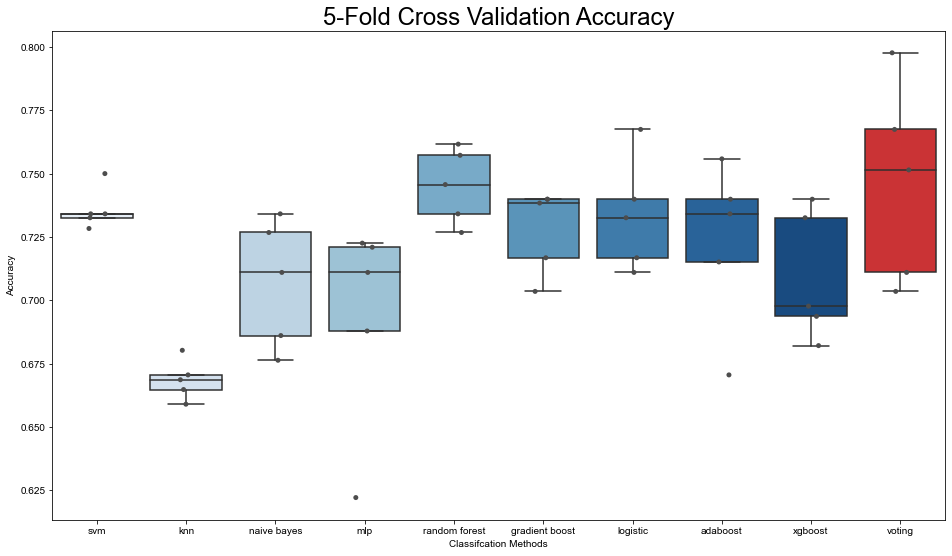

In [34]:
plt.subplots(figsize=(16, 9))
sns.set(style="ticks")
sns.set(font_scale=2.0)
colors = sns.color_palette("Blues", len(base_learners.keys()))
colors.append((0.8901960784313725, 0.10196078431372549, 0.10980392156862745))
dx = sns.boxplot(data=cv_results, palette=colors, boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(data=cv_results,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
dx.set(xlabel='Classifcation Methods',ylabel='Accuracy', title='5-Fold Cross Validation Accuracy')

In [35]:
P_test = predict_base_learners(base_learners, z_score_normalize(np.array(test_dataset[feature])))
test_dataset['prediction_clinical'] = P_test.mean(axis=1)
test_dataset.to_csv('./csv/prediction_testSet/filled_{}_binary.txt'.format(method))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
